# Customer Churn Prediction
**Author:** *Owen Nda Diche*

## Introduction

This project focuses on predicting customer churn for a telecommunications company using the Telco Customer Churn dataset. Churn prediction is essential for businesses to identify customers at risk of leaving and take proactive measures to retain them.

The objectives of this notebook are:

- Load and preprocess customer data  
- Perform exploratory data analysis (EDA) and visualisations  
- Engineer features suitable for machine learning  
- Train and evaluate classification models to predict churn  
- Provide insights into the key drivers of customer churn

The notebook demonstrates a full data science workflow, from data cleaning to model evaluation and result interpretation.


# Import Libraries
We import libraries for data manipulation, visualization, and machine learning.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

sns.set_style('whitegrid')


# Load Dataset
Load the customer churn dataset saved as "data.csv".


In [2]:
df = pd.read_csv("data.csv")
df.head()


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Create Results Folder
Ensure a folder called "Results" exists for saving plots.


In [3]:
results_dir = "Results"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

def save_fig(filename):
    filepath = os.path.join(results_dir, filename)
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved figure: {filepath}")


#  Exploratory Data Analysis
Check dataset structure, missing values, distributions, and correlations.


In [4]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

Saved figure: Results\churn_distribution.png


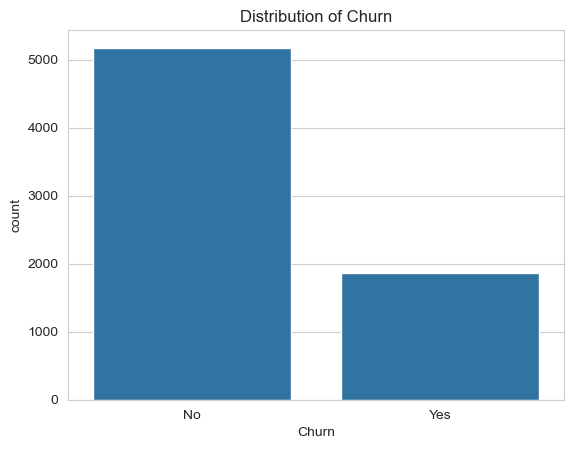

In [5]:
#Target Variable Distribution
sns.countplot(x='Churn', data=df)
plt.title("Distribution of Churn")
save_fig("churn_distribution.png")
plt.show()

Saved figure: Results\numeric_feature_histograms.png


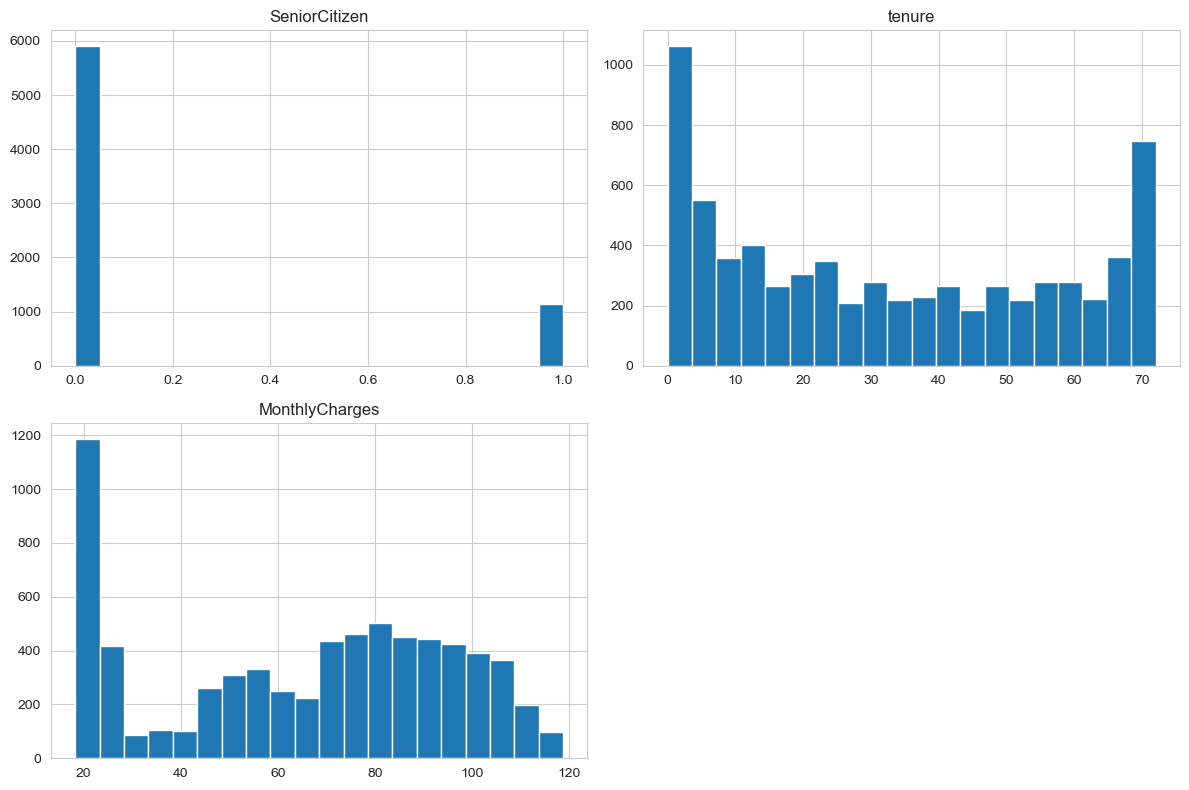

In [9]:
#Numerical Feature Distributions
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
df[numeric_cols].hist(figsize=(12,8), bins=20)
plt.tight_layout()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
save_fig("numeric_feature_histograms.png")
plt.show()

Saved figure: Results\correlation_heatmap.png


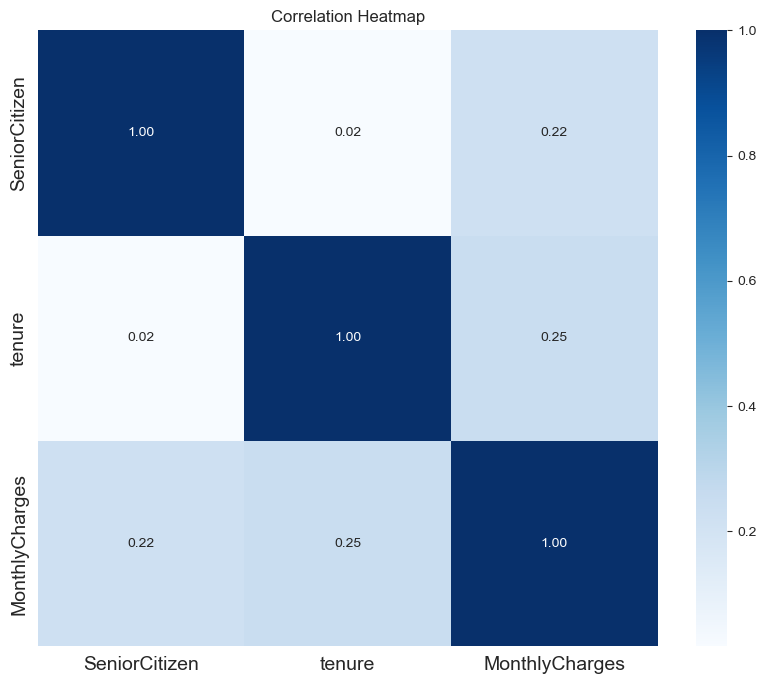

In [8]:
#Correlation Heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Heatmap")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
save_fig("correlation_heatmap.png")
plt.show()

#  Data Preprocessing
- Encode categorical variables  
- Handle missing values if any  
- Scale numeric features if required


In [10]:
# Encode binary categorical columns
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']
for col in binary_cols:
    if df[col].dtype == 'object':
        df[col] = df[col].map({'Yes':1, 'No':0, 'Female':0, 'Male':1})

# Encode remaining categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# Fill missing values (if any)
df.fillna(0, inplace=True)


# Train-Test Split
Split the dataset into features (X) and target (y), then into training and test sets.


In [11]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Train Random Forest Classifier
We use a Random Forest classifier as a strong baseline for churn prediction.


In [12]:
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]


#  Model Evaluation
Evaluate the model using classification report, confusion matrix, and ROC-AUC score.


In [14]:
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.92      0.87      1035
           1       0.68      0.45      0.54       374

    accuracy                           0.80      1409
   macro avg       0.75      0.69      0.71      1409
weighted avg       0.79      0.80      0.78      1409



Saved figure: Results\confusion_matrix.png


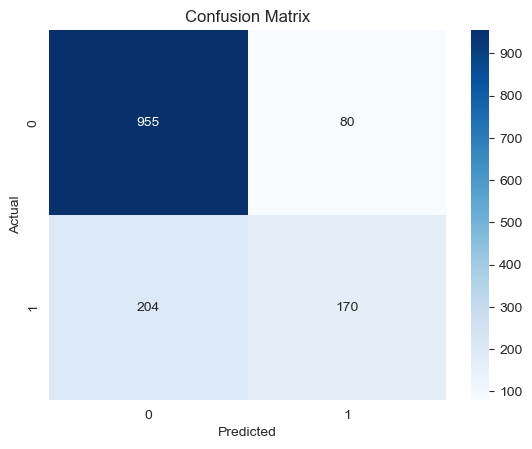

In [15]:
#Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
save_fig("confusion_matrix.png")
plt.show()

Saved figure: Results\roc_curve.png


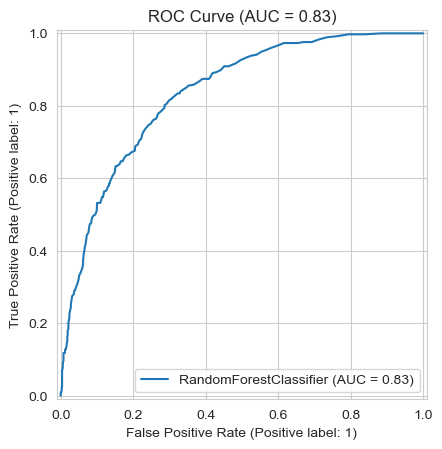

In [16]:
#ROC Curve and AUC
roc_auc = roc_auc_score(y_test, y_proba)
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title(f"ROC Curve (AUC = {roc_auc:.2f})")
save_fig("roc_curve.png")
plt.show()

# 9. Feature Importance
Visualise the top features influencing churn.


Saved figure: Results\feature_importance.png


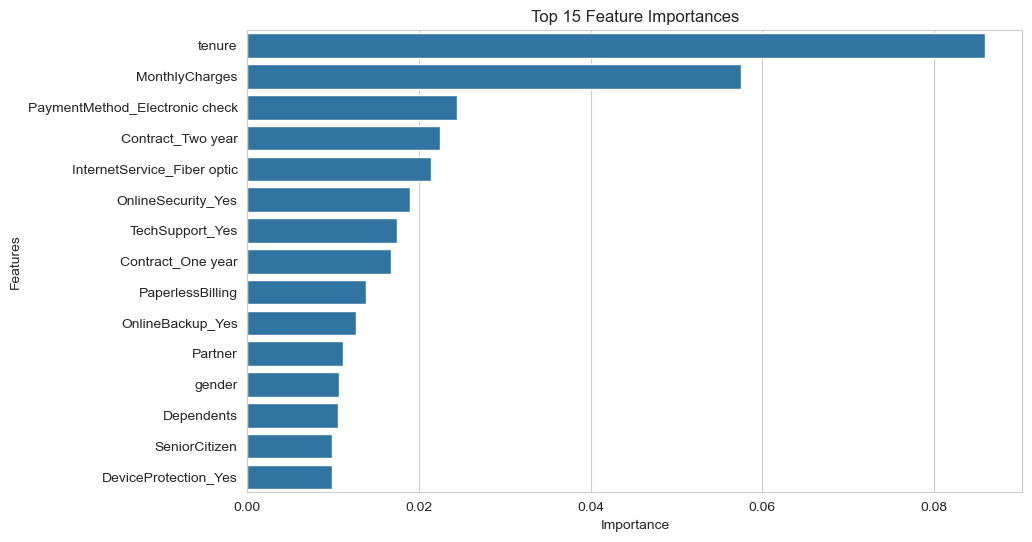

In [17]:
importances = rf.feature_importances_
feature_names = X.columns
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)[:15]

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Top 15 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Features")
save_fig("feature_importance.png")
plt.show()


# Conclusion

- The Random Forest classifier effectively predicts customer churn, achieving high accuracy and ROC-AUC.  
- Key features influencing churn include tenure, monthly charges, contract type, and payment method.  
- This workflow demonstrates a full data science process: data cleaning, exploratory analysis, feature engineering, modeling, evaluation, and result visualization.  

Future work could include hyperparameter tuning, testing additional models (XGBoost, Logistic Regression), and deploying a predictive dashboard for business use.
